In [118]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
# 데이터1 불러오기 
data1 = pd.read_csv('220205_220211_유효_무효.csv', error_bad_lines=False) #에러가 있는 행은 제외함

#print(data1)
# ADDRESS 컬럼의 값이 active_pw와 reactive_pw인 경우, 각각의 값을 컬럼으로 변환
data1 = data1.pivot_table(index=['_time', 'GIMAC_ID', 'DIV'], columns='ADDRESS', values='Value').reset_index()

# 컬럼 이름 변경
data1 = data1.rename(columns={'active_pw': 'active', 'reactive_pw': 'reactive'})

data1 = data1[['_time', 'active', 'reactive']] #불필요한 컬럼 제외

# _time 컬럼을 기준으로 내림차순으로 데이터 정렬
data1 = data1.sort_values(by='_time', ascending=True) #결측치는 없으므로 일단 결측치 처리 코드 구현안함

#시간 함수를 날짜, 시간, 옵셋으로 분할하기
data1[['date', 'time', 'offset']] = data1['_time'].str.split('[T+]', expand=True)
data1_clean = data1[['date', 'time', 'active', 'reactive']]

# date 컬럼을 datetime 형태로 변환
data1_clean['date'] = pd.to_datetime(data1_clean['date'])

#23년 2월 이후 데이터만을 분석 모델에 사용하기 위해 date가 23-02보다 작은 행을 버림.
# 2023년 02월 이전의 행 제외
data1_clean = data1_clean[data1_clean['date'] >= '2023-02-01']

print(data1_clean) #1시간단위 전력 데이터 전처리 완료 ==> DATA1





ADDRESS       date          time        active      reactive
1976    2023-02-01  09:00:00.000  251116.46150  226173.58942
1977    2023-02-01  10:00:00.000  581891.10649  422444.95267
1978    2023-02-01  11:00:00.000  644022.11148  447294.97388
1979    2023-02-01  12:00:00.000  526999.11135  422848.10906
1980    2023-02-01  13:00:00.000  524702.32748  417124.37939
...            ...           ...           ...           ...
2052    2023-02-10  14:00:00.000  463257.59131  393264.01442
2053    2023-02-10  15:00:00.000  486652.30059  400298.22265
2054    2023-02-10  16:00:00.000  506382.65771  426823.82026
2055    2023-02-10  17:00:00.000  627925.42612  507299.51736
2056    2023-02-10  18:00:00.000  181962.09522  156317.63695

[81 rows x 4 columns]


C:\Users\kris\AppData\Local\Temp\ipykernel_7688\4172896368.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data1 = pd.read_csv('220205_220211_유효_무효.csv', error_bad_lines=False) #에러가 있는 행은 제외함
C:\Users\kris\AppData\Local\Temp\ipykernel_7688\4172896368.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_clean['date'] = pd.to_datetime(data1_clean['date'])


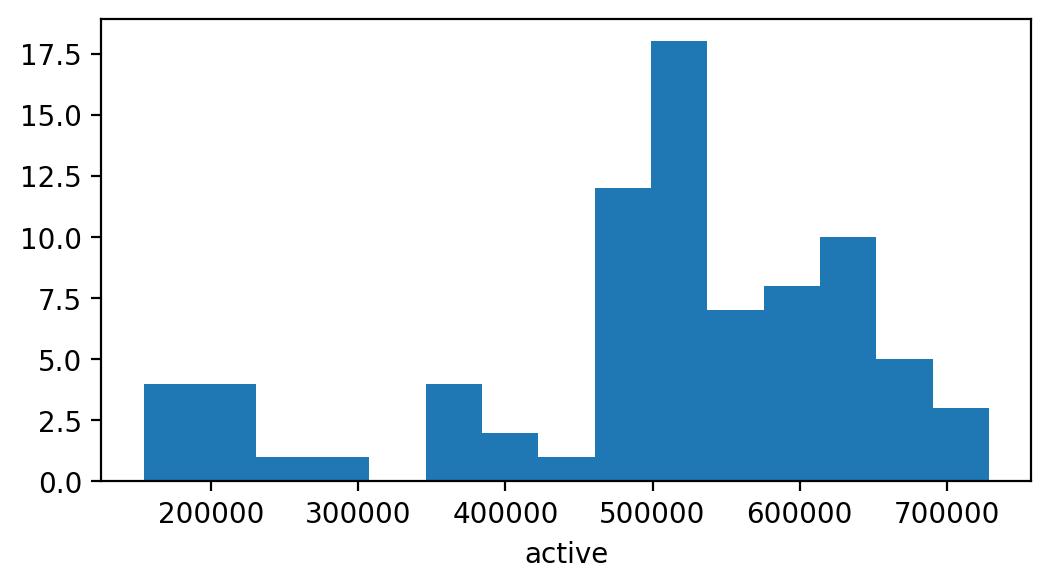

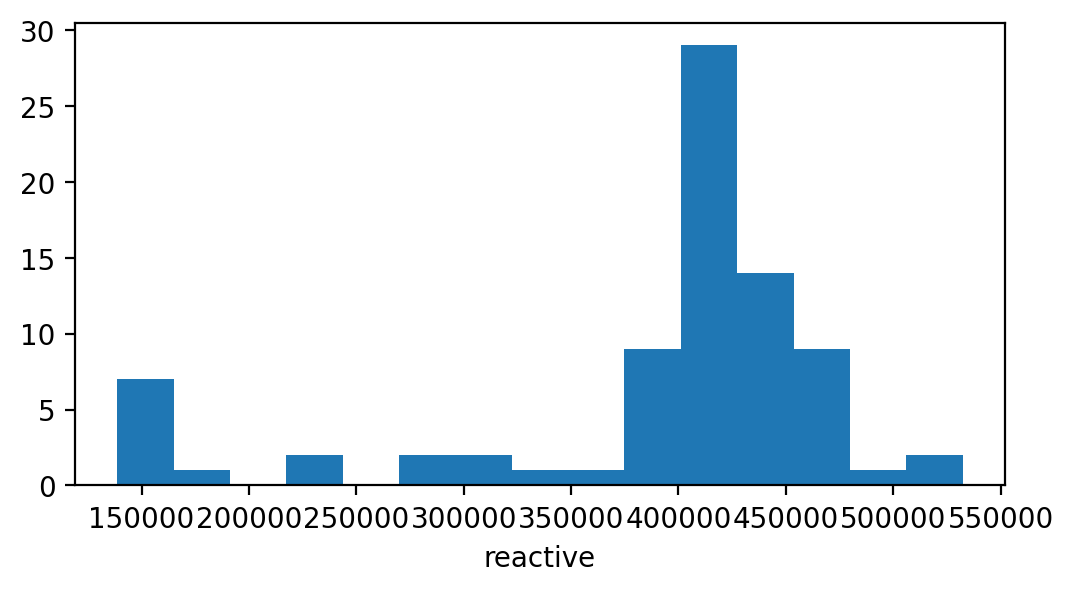

In [123]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(6,3))
#plt.hist(data1.active, bins=35)   
plt.hist(data1_clean.active, bins=15) 
plt.xlabel('active')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(data1_clean.reactive, bins=15)
plt.xlabel('reactive')
plt.show()

# DATA1 셋의 분석결과 분포가 너무 다양하여, 위 데이터를 바탕으로 역률을 구해 새로운 컬럼을 생성함.

In [120]:
#역률 생성하여 DATA1 신규 컬럼 생성
# 역률은 유효/피상, 
# 피상은 sqrt (유효^2+ 무효^2)
#########################

#PF 컬럼 생성
data1_clean['pf'] = data1_clean['active']/np.sqrt(data1_clean['active']**2 + data1_clean['reactive']**2)
data1_clean = data1_clean.dropna() #결측치 제외
#data1_new = data1_clean[data1_clean.columns.difference([ 'active','reactive'])]
data1_new = data1_clean[['date','time','pf']]

print(data1_new)


ADDRESS       date          time        pf
1976    2023-02-01  09:00:00.000  0.743046
1977    2023-02-01  10:00:00.000  0.809231
1978    2023-02-01  11:00:00.000  0.821336
1979    2023-02-01  12:00:00.000  0.779966
1980    2023-02-01  13:00:00.000  0.782785
...            ...           ...       ...
2052    2023-02-10  14:00:00.000  0.762349
2053    2023-02-10  15:00:00.000  0.772299
2054    2023-02-10  16:00:00.000  0.764616
2055    2023-02-10  17:00:00.000  0.777863
2056    2023-02-10  18:00:00.000  0.758535

[80 rows x 3 columns]


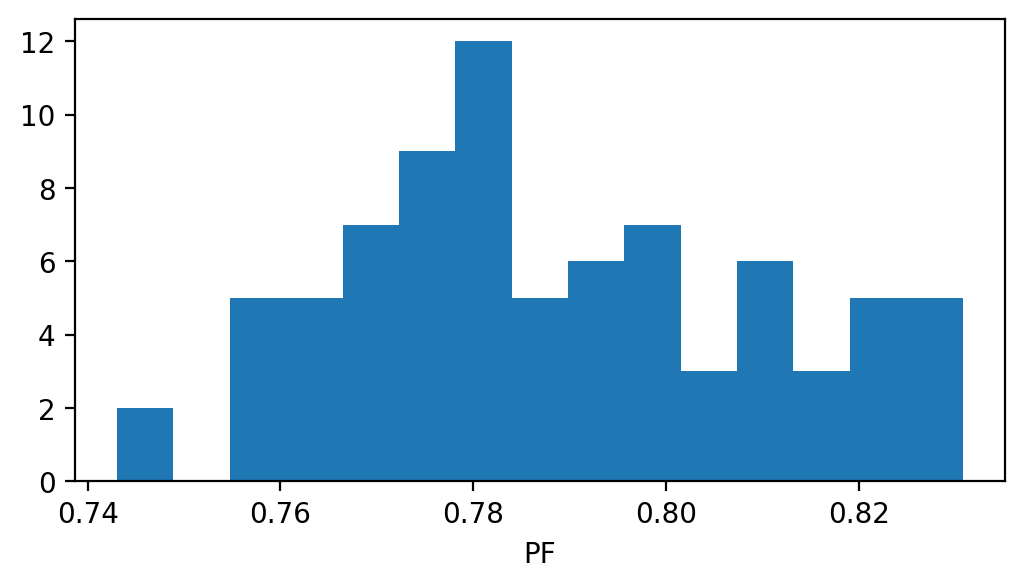

In [127]:
#새로 생성된 역률 값의 분포를 확인함
plt.figure(figsize=(6,3))
#plt.hist(data1.active, bins=35)   
plt.hist(data1_new.pf, bins=15) 
plt.xlabel('PF')
plt.show()

data1_new.to_csv('PF.csv', index=False)

# 대충 정규분포 스러우므로 사용하기로 함. data1_new 확정

In [145]:
###############################################################
# 3~5초짜리 PQ 데이터 전처리 시작 -- DATA2

data2 = pd.read_csv('20230205_20230211_전력데이터.csv',error_bad_lines=False) #이상 행 제외하고 로드
data2 = data2[data2['GIMAC_ID'] == 'G1_ABN-100'] # ID가 G1_ABN-100 인 항목만 사용
data2 = data2[['NAME', 'Value', '_time']] # 항목과 값, 시간만 사용 
# 뺄때는 difference 사용
#data2 = data2[data2.columns.difference([ , , ])]
data2 = data2.sort_values(by='_time', ascending=True) #시간으로 내림차순 정렬 
data2[['date', 'time', 'offset']] = data2['_time'].str.split('[T+]', expand=True) #시간 함수를 날짜, 시간, 옵셋으로 분할하기
data2 = data2[['date','time', 'NAME', 'Value']] #필요한 항목만 남김.

# NAME 컬럼값으로 컬럼 생성하기
#data2 = data2.set_index('NAME', append=True).unstack('NAME')['Value'].reset_index()




print("--------------------------------------------")
print(data2)
print("--------------------------------------------")

unique_values = data2['NAME'].unique() #NAME 컬럼이 가지는 값(항목) 종류 추출
print(unique_values)
#['THD_Vca' 'THD_Vab' 'THD_Vbc' 'active_en' 'TDD_Ic' 'TDD_Ia' 'THD_Ic'
# 'THD_Ib' 'THD_Ia' 'TDD_Ib' 'Ib' 'Ia' 'Ic' 'leak' nan 'active_en_gwh'
# 'THD_Vb' 'THD_Va' 'THD_Vc']
# 위 항목중 전류 THD와 TDD만 사용하기로 함.

# NAME 컬럼이 'THD_Vca'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Vca']
# NAME 컬럼이 'THD_Vab'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Vab']
# NAME 컬럼이 'THD_Vbc'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Vbc']
# NAME 컬럼이 'active_en'인 행 제외
data2 = data2[data2['NAME'] != 'active_en']
# NAME 컬럼이 'Ib'인 행 제외
data2 = data2[data2['NAME'] != 'Ib']
# NAME 컬럼이 'Ia'인 행 제외
data2 = data2[data2['NAME'] != 'Ia']
# NAME 컬럼이 'Ic'인 행 제외
data2 = data2[data2['NAME'] != 'Ic']
# NAME 컬럼이 nan인 행 제외
data2 = data2.dropna()
# NAME 컬럼이 'active_en_gwh'인 행 제외
data2 = data2[data2['NAME'] != 'active_en_gwh']
# NAME 컬럼이 'THD_Vb'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Vb']
# NAME 컬럼이 'THD_Va'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Va']
# NAME 컬럼이 'THD_Vc'인 행 제외
data2 = data2[data2['NAME'] != 'THD_Vc']

print(data2)
data2.to_csv('PQ.csv',index=False)
# NAME 컬럼의 값이 아이템명이므로 컬럽의 값을 신규 컬럼으로 변환 

data2_new = pd.pivot_table(data2, index=['date', 'time'], columns='NAME', values='Value').reset_index()

# 'NAME' 컬럼의 'VALUE' 값 추출, 해당 컬럼의 내용은 'Value' 값으로 변경





C:\Users\kris\AppData\Local\Temp\ipykernel_7688\688969966.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data2 = pd.read_csv('20230205_20230211_전력데이터.csv',error_bad_lines=False) #이상 행 제외하고 로드
Skipping line 102178: expected 29 fields, saw 55

Skipping line 186182: expected 29 fields, saw 39

C:\Users\kris\AppData\Local\Temp\ipykernel_7688\688969966.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('20230205_20230211_전력데이터.csv',error_bad_lines=False) #이상 행 제외하고 로드


--------------------------------------------
              date          time     NAME       Value
366421  2023-02-06  08:09:01.189       Ia           0
366418  2023-02-06  08:09:01.189     leak           0
366420  2023-02-06  08:09:01.189       Ib           0
366419  2023-02-06  08:09:01.189       Ic           0
366407  2023-02-06  08:09:01.517   TDD_Ib           0
...            ...           ...      ...         ...
3       2023-02-10  17:25:15.823  THD_Vca  2.01456499
2       2023-02-10  17:25:21.292  THD_Vab  2.05293584
1       2023-02-10  17:25:21.292  THD_Vbc  2.49921227
0       2023-02-10  17:25:21.292  THD_Vca           0
186176         NaN           NaN  THD_Vca       gimac

[366422 rows x 4 columns]
--------------------------------------------
['Ia' 'leak' 'Ib' 'Ic' 'TDD_Ib' 'TDD_Ia' 'THD_Vca' 'THD_Vbc' 'THD_Vab'
 'THD_Ia' 'THD_Vb' 'THD_Ib' 'THD_Vc' 'THD_Va' 'THD_Ic' 'TDD_Ic' nan
 'active_en' 'active_en_gwh']
              date          time    NAME Value
366418  2023-02-06 

C:\Users\kris\AppData\Local\Temp\ipykernel_7688\688969966.py:59: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  data2_new = pd.pivot_table(data2, index=['date', 'time'], columns='NAME', values='Value').reset_index()
